# Football Players Pose Estimation Animation

## 00. Setup

In [1]:
FRAME_WIDTH = 1920
FRAME_HEIGHT = 1080

In [2]:
VIEW_X_MIN = - 500
VIEW_X_MAX = 500
VIEW_Y_MIN = - 500
VIEW_Y_MAX = 500
VIEW_Z_MIN = 0
VIEW_Z_MAX = 1000

POSE_ANCHORS = [
    [0,1],
    [0,2],
    [1,3],
    [2,4],
    [5,6],
    [5,7],
    [6,8],
    [7,9],
    [8,10],
    [5,11],
    [6,12],
    [11,12],
    [11,13],
    [12,14],
    [13,15],
    [14,16]
]

In [3]:
import os
HOME = os.getcwd()
print(HOME)

/content


## 01. Download data

In [4]:
%cd {HOME}
!mkdir extracted_data
%cd {HOME}/extracted_data
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=16kaI-u0o2jdelM32VUaTlSbwI8VfsB6P' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=16kaI-u0o2jdelM32VUaTlSbwI8VfsB6P" -O pose-estimation-synchronised-sample-a.json && rm -rf /tmp/cookies.txt
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1V34envDNz8877yMWtzsPKdwoLjFXASAG' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1V34envDNz8877yMWtzsPKdwoLjFXASAG" -O pose-estimation-synchronised-sample-b.json && rm -rf /tmp/cookies.txt

/content
/content/extracted_data
--2022-12-14 15:41:43--  https://docs.google.com/uc?export=download&confirm=&id=16kaI-u0o2jdelM32VUaTlSbwI8VfsB6P
Resolving docs.google.com (docs.google.com)... 172.217.164.174, 2607:f8b0:4004:815::200e
Connecting to docs.google.com (docs.google.com)|172.217.164.174|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-10-3k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/26hdpu4tdtn8ujhc27k1ekegg868uvgc/1671032475000/03460023843299134270/*/16kaI-u0o2jdelM32VUaTlSbwI8VfsB6P?e=download&uuid=7207f909-a5e5-44b1-bbd6-7cd1b72025dc [following]
--2022-12-14 15:41:43--  https://doc-10-3k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/26hdpu4tdtn8ujhc27k1ekegg868uvgc/1671032475000/03460023843299134270/*/16kaI-u0o2jdelM32VUaTlSbwI8VfsB6P?e=download&uuid=7207f909-a5e5-44b1-bbd6-7cd1b72025dc
Resolving doc-10-3k-docs.googleusercontent.com (doc-10-3k-docs.googleusercontent.c

In [5]:
EXTRACTED_DATA_A_PATH = f"{HOME}/extracted_data/pose-estimation-synchronised-sample-a.json"
EXTRACTED_DATA_B_PATH = f"{HOME}/extracted_data/pose-estimation-synchronised-sample-b.json"

## 02. Load data

In [6]:
from dataclasses import dataclass
from typing import List

import numpy as np

import json


@dataclass
class FrameData:
    pose: np.ndarray
    detection: np.ndarray


def load_json(path: str) -> dict:
    with open(path) as f:
        contents = f.read()
        return json.loads(contents)


def load_extracted_data(path: str) -> List[FrameData]:
    raw = load_json(path)
    return [
        FrameData(
            pose=entry['pose'],
            detection=entry['detection']
        )
        for entry
        in raw
    ]

In [7]:
extracted_data_a = load_extracted_data(EXTRACTED_DATA_A_PATH)
extracted_data_b = load_extracted_data(EXTRACTED_DATA_B_PATH)

### Baseline pose visualization

In [8]:
from __future__ import annotations
from dataclasses import dataclass
from typing import Optional, List, Tuple


@dataclass
class Pose:
    x: np.ndarray
    y: np.ndarray
    confidence: np.ndarray

    @classmethod
    def load(cls, data: List[float]) -> Pose:
        x, y, confidence = [], [], []
        for i in range(17):
            x.append(data[7 + i * 3])
            y.append(data[7 + i * 3 + 1])
            confidence.append(data[7 + i * 3 + 2])
        return Pose(
            x=np.array(x),
            y=np.array(y),
            confidence=np.array(confidence)
        )


@dataclass
class Pose3D:
    x: np.ndarray
    y: np.ndarray
    z: np.ndarray

    @classmethod
    def from2D(cls, pose_a: Pose, pose_b: Pose) -> Pose3D:
        return Pose3D(
            x=pose_a.x,
            y=pose_b.x,
            z=pose_a.y
        )


@dataclass
class Point:
    x: float
    y: float
    
    @property
    def int_xy_tuple(self) -> Tuple[int, int]:
        return int(self.x), int(self.y)


@dataclass
class Point3D:
    x: float
    y: float
    z: float
    
    @property
    def int_xyz_tuple(self) -> Tuple[int, int, int]:
        return int(self.x), int(self.y), int(self.z)

    @classmethod
    def from2D(cls, point_a: Point, point_b: Point) -> Point3D:
        return Point3D(
            x=point_a.x,
            y=point_b.x,
            z=point_a.y
        )


@dataclass
class Detection:
    x_min: float
    y_min: float
    x_max: float
    y_max: float
    confidence: float
    class_id: int

    @property
    def width(self) -> float:
        return self.x_max - self.x_min

    @property
    def height(self) -> float:
        return self.y_max - self.y_min

    @property
    def center(self) -> Point:
        return Point(
            x=(self.x_min + self.x_max) / 2,
            y=(self.y_min + self.y_max) / 2
        )

    @classmethod
    def load(cls, data: List[float]) -> Detection:
        return Detection(
            x_min=float(data[0]),
            y_min=float(data[1]),
            x_max=float(data[2]),
            y_max=float(data[3]),
            confidence=float(data[4]),
            class_id=int(data[5])
        )

    @classmethod
    def filter(cls, detections: List[Detection], class_id: int) -> Optional[Detection]:
        filtered_detections = [
            detection
            for detection
            in detections
            if detection.class_id == class_id
        ]
        return filtered_detections[0] if len(filtered_detections) == 1 else None

In [9]:
pose_a = Pose.load(extracted_data_a[0].pose[0])

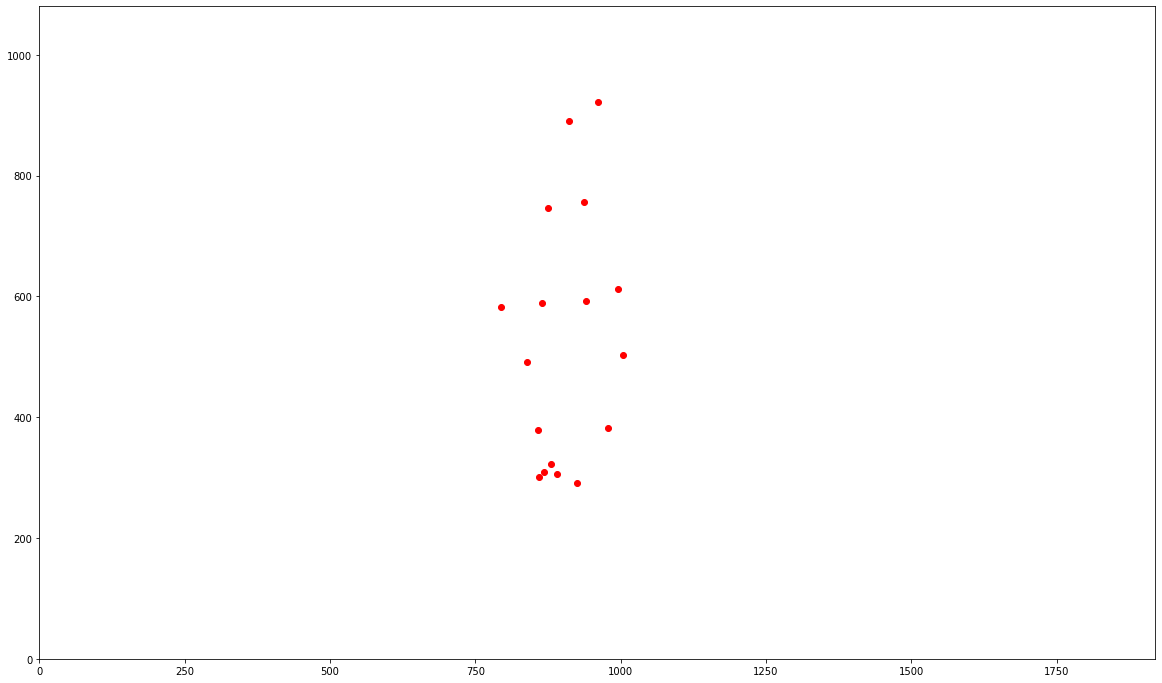

In [10]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 12))
plt.scatter(pose_a.x, pose_a.y, color="red")
plt.xlim([0, FRAME_WIDTH])
plt.ylim([0, FRAME_HEIGHT])
plt.show()

In [11]:
pose_b = Pose.load(extracted_data_b[0].pose[0])

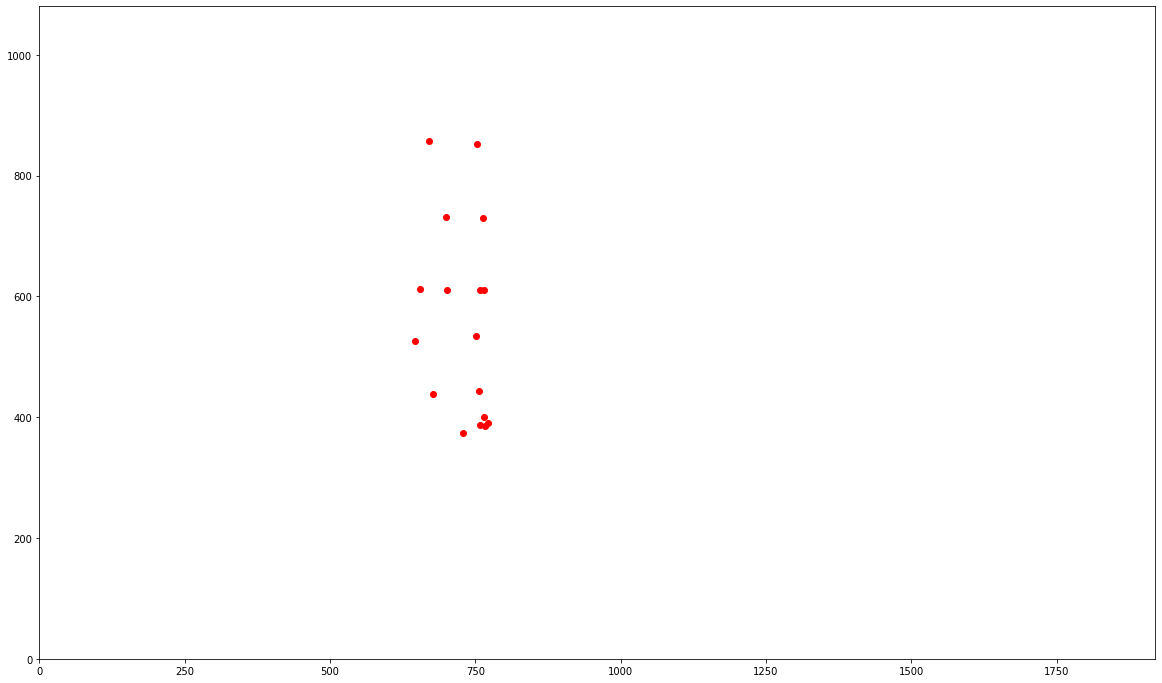

In [12]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 12))
plt.scatter(pose_b.x, pose_b.y, color="red")
plt.xlim([0, FRAME_WIDTH])
plt.ylim([0, FRAME_HEIGHT])
plt.show()

## 03. Calibrate

In [15]:
detections = [Detection.load(detection) for detection in extracted_data_a[0].detection]
detection_a = Detection.filter(detections, 0)
pose_a = Pose.load(extracted_data_a[0].pose[0])
BASELINE_HEIGHT_A = detection_a.height
BASELINE_VERTICAL_OFFSET_A = detection_a.y_max - pose_a.y.max()
print("BASELINE_HEIGHT_A", BASELINE_HEIGHT_A)
print("BASELINE_VERTICAL_OFFSET_A", BASELINE_VERTICAL_OFFSET_A)

detections = [Detection.load(detection) for detection in extracted_data_b[0].detection]
detection_b = Detection.filter(detections, 0)
pose_b = Pose.load(extracted_data_b[0].pose[0])
BASELINE_VERTICAL_OFFSET_B = detection_b.y_max - pose_b.y.max()
BASELINE_HEIGHT_B = detection_b.height
print("BASELINE_HEIGHT_B", BASELINE_HEIGHT_B)
print("BASELINE_VERTICAL_OFFSET_B", BASELINE_VERTICAL_OFFSET_B)

BASELINE_HEIGHT_A 800.3152923583984
BASELINE_VERTICAL_OFFSET_A 92.08135986328125
BASELINE_HEIGHT_B 606.7469177246094
BASELINE_VERTICAL_OFFSET_B 67.94122314453125


In [16]:
from typing import Optional, Tuple


def calibrate(
    data: FrameData, 
    frame_height: int, 
    baseline_pose_height: float,
    baseline_vertical_offset: float
) -> Optional[Tuple[Pose, Point]]:
    detections = [Detection.load(detection) for detection in data.detection]
    detection_person = Detection.filter(detections, 0)
    detection_ball = Detection.filter(detections, 32)
    
    if detection_person is None:
        return None
    if detection_ball is None:
        return None
    if len(data.pose) != 1:
        return None

    ball_x, ball_y = detection_ball.center.int_xy_tuple

    pose = Pose.load(data.pose[0])
    pose.y = frame_height - pose.y
    ball_y = frame_height - ball_y

    x_shift = (pose.x.max() + pose.x.min()) / 2
    y_shift = pose.y.min() - baseline_vertical_offset

    pose.x = pose.x - x_shift
    ball_x = ball_x - x_shift
    pose.y = (pose.y - y_shift) * 1000 / baseline_pose_height
    ball_y = (ball_y - y_shift) * 1000 / baseline_pose_height
    return pose, Point(x=ball_x, y=ball_y)

In [17]:
pose_a, point_a = calibrate(extracted_data_a[0], FRAME_HEIGHT, BASELINE_HEIGHT_A, BASELINE_VERTICAL_OFFSET_A)

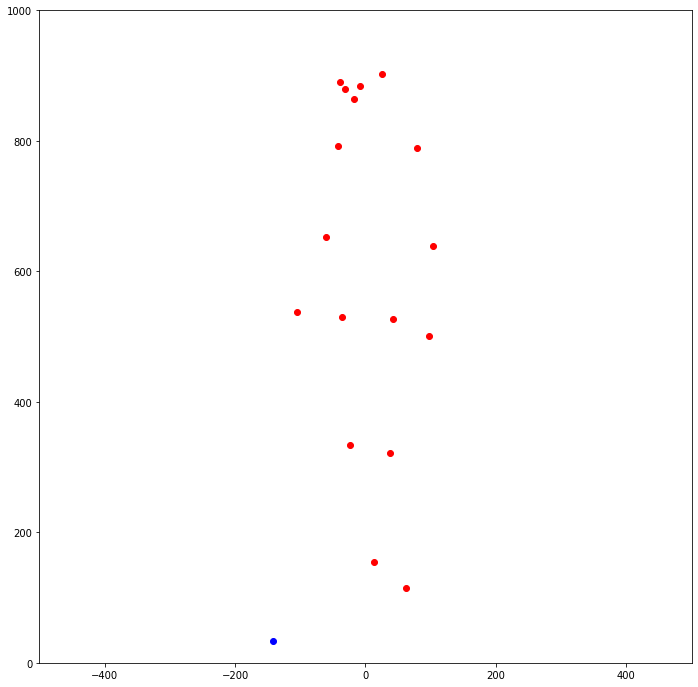

In [19]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 12))
plt.scatter(pose_a.x, pose_a.y, color="red")
plt.scatter([point_a.x], [point_a.y], color="blue")
plt.xlim([VIEW_X_MIN, VIEW_X_MAX])
plt.ylim([VIEW_Z_MIN, VIEW_Z_MAX])
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.show()

In [20]:
pose_b, point_b = calibrate(extracted_data_b[0], FRAME_HEIGHT, BASELINE_HEIGHT_B, BASELINE_VERTICAL_OFFSET_B)

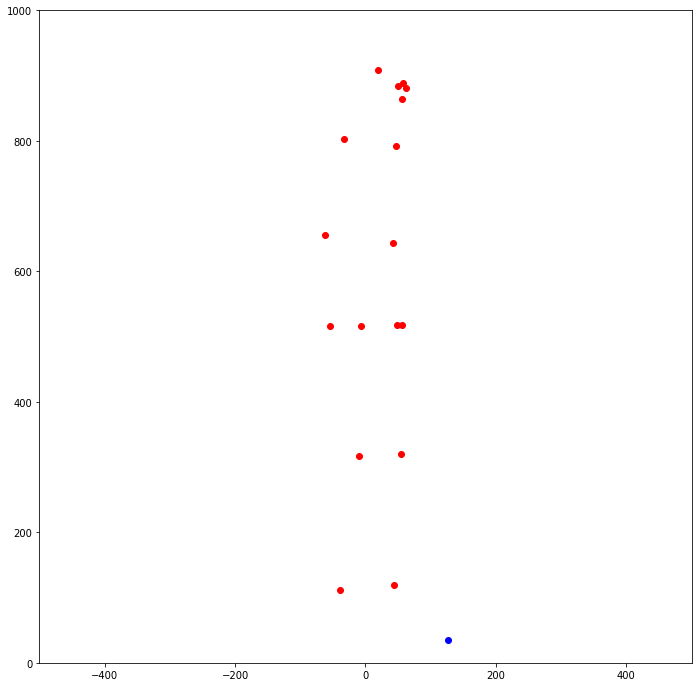

In [21]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 12))
plt.scatter(pose_b.x, pose_b.y, color="red")
plt.scatter([point_b.x], [point_b.y], color="blue")
plt.xlim([VIEW_X_MIN, VIEW_X_MAX])
plt.ylim([VIEW_Z_MIN, VIEW_Z_MAX])
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.show()

In [22]:
pose_a, point_a = calibrate(extracted_data_a[0], FRAME_HEIGHT, BASELINE_HEIGHT_A, BASELINE_VERTICAL_OFFSET_A)
pose_b, point_b = calibrate(extracted_data_b[0], FRAME_HEIGHT, BASELINE_HEIGHT_B, BASELINE_VERTICAL_OFFSET_B)

pose3d = Pose3D.from2D(pose_a=pose_a, pose_b=pose_b)
point3d = Point3D.from2D(point_a=point_a, point_b=point_b)

In [23]:
from typing import Tuple, List

from collections import deque


class Trace:

    def __init__(self, history: int = 10):
        self.x = deque(maxlen=history)
        self.y = deque(maxlen=history)
        self.z = deque(maxlen=history)

    def append(self, x: float, y: float, z: float):
        self.x.append(x)
        self.y.append(y)
        self.z.append(z)

    def get_state(self) -> Tuple[List[float], List[float], List[float]]:
        return list(self.x), list(self.y), list(self.z)

In [31]:
from typing import Optional
import matplotlib.pyplot as plt
import random

def draw_3d(
    pose3d: Pose3D, 
    ball3d: Point3D, 
    angle: int = 0, 
    save_path: Optional[str] = None, 
    ball_trace: Optional[Trace] = None,
    foot_1_trace: Optional[Trace] = None,
    foot_2_trace: Optional[Trace] = None,
) -> None:

    plt.style.use('dark_background')

    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(projection='3d')

    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

    ax.axes.set_xlim3d(left=VIEW_X_MIN, right=VIEW_X_MAX)
    ax.axes.set_ylim3d(bottom=VIEW_Y_MIN, top=VIEW_Y_MAX) 
    ax.axes.set_zlim3d(bottom=VIEW_Z_MIN, top=VIEW_Z_MAX)

    for pose_anchor in POSE_ANCHORS:
        ax.plot(pose3d.x[pose_anchor], pose3d.y[pose_anchor], pose3d.z[pose_anchor], color="#ffffff", linewidth=5)

    if ball_trace is not None:
        ball_trace_x, ball_trace_y, ball_trace_z = ball_trace.get_state()
        ax.plot(ball_trace_x, ball_trace_y, ball_trace_z, color="#e84a5f", linewidth=2)

    if foot_1_trace is not None:
        foot_1_trace_x, foot_1_trace_y, foot_1_trace_z = foot_1_trace.get_state()
        ax.plot(foot_1_trace_x, foot_1_trace_y, foot_1_trace_z, color="#fecea8", linewidth=2)

    if foot_2_trace is not None:
        foot_2_trace_x, foot_2_trace_y, foot_2_trace_z = foot_2_trace.get_state()
        ax.plot(foot_2_trace_x, foot_2_trace_y, foot_2_trace_z, color="#fecea8", linewidth=2)

    ax.scatter(pose3d.x, pose3d.y, pose3d.z, color="#ffffff")
    ax.scatter(ball3d.x, ball3d.y, ball3d.z, color="#e84a5f", s=500)
    ax.view_init(30, 45 + angle*2)

    if save_path is None:
        plt.show()
    else:
        plt.savefig(save_path)
        plt.close(fig)

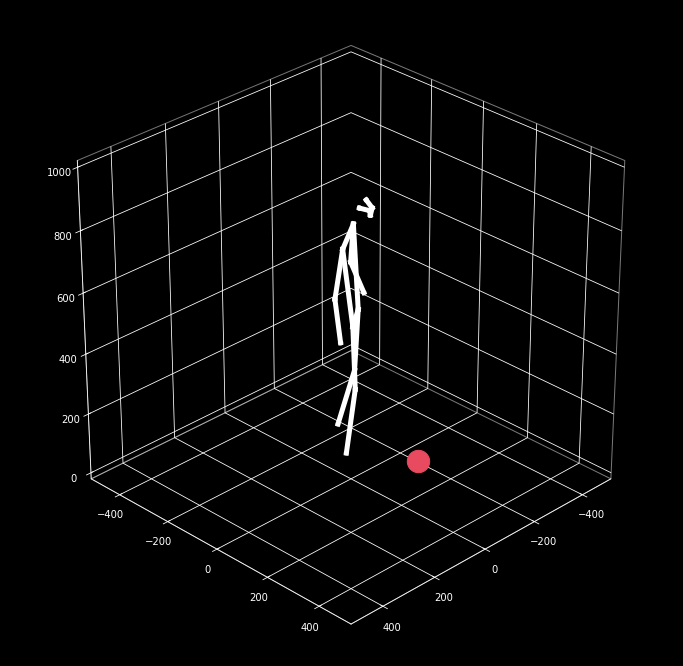

In [25]:
draw_3d(pose3d, point3d)

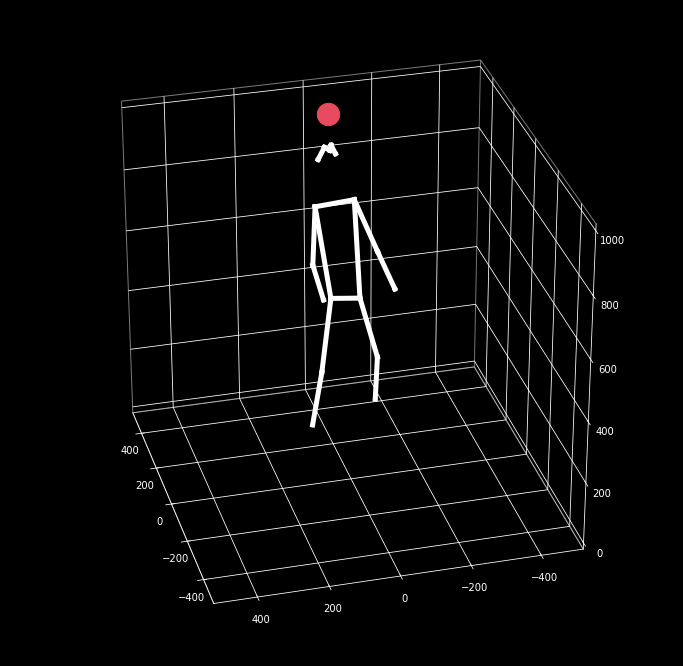

In [33]:
pose_a, point_a = calibrate(extracted_data_a[320], FRAME_HEIGHT, BASELINE_HEIGHT_A, BASELINE_VERTICAL_OFFSET_A)
pose_b, point_b = calibrate(extracted_data_b[320], FRAME_HEIGHT, BASELINE_HEIGHT_B, BASELINE_VERTICAL_OFFSET_B)

pose3d = Pose3D.from2D(pose_a=pose_a, pose_b=pose_b)
point3d = Point3D.from2D(point_a=point_a, point_b=point_b)

draw_3d(pose3d, point3d, 60)

In [27]:
OUTPUT_DIR = "frames"

In [28]:
%cd {HOME}
!mkdir -p $OUTPUT_DIR

/content


In [29]:
from tqdm.notebook import trange


def generate_frames(start=0, end=100):
    ball_trace = Trace(20)
    foot_1_trace = Trace(10)
    foot_2_trace = Trace(10)
    for i in trange(start, end):
        a = calibrate(extracted_data_a[i], FRAME_HEIGHT, BASELINE_HEIGHT_A, BASELINE_VERTICAL_OFFSET_A)
        b = calibrate(extracted_data_b[i], FRAME_HEIGHT, BASELINE_HEIGHT_B, BASELINE_VERTICAL_OFFSET_B)

        if a is None or b is None:
            continue

        pose_a, point_a = a
        pose_b, point_b = b

        pose3d = Pose3D.from2D(pose_a=pose_a, pose_b=pose_b)
        point3d = Point3D.from2D(point_a=point_a, point_b=point_b)
        ball_trace.append(x=point3d.x, y=point3d.y, z=point3d.z)
        foot_1_trace.append(x=pose3d.x[-1], y=pose3d.y[-1], z=pose3d.z[-1])
        foot_2_trace.append(x=pose3d.x[-2], y=pose3d.y[-2], z=pose3d.z[-2])

        file_name = "file%04d.png" % i
        draw_3d(pose3d, point3d, angle=i // 2, save_path=f"{HOME}/{OUTPUT_DIR}/{file_name}", ball_trace=ball_trace, foot_1_trace=foot_1_trace, foot_2_trace=foot_2_trace)

  0%|          | 0/2239 [00:00<?, ?it/s]

SystemError: ignored

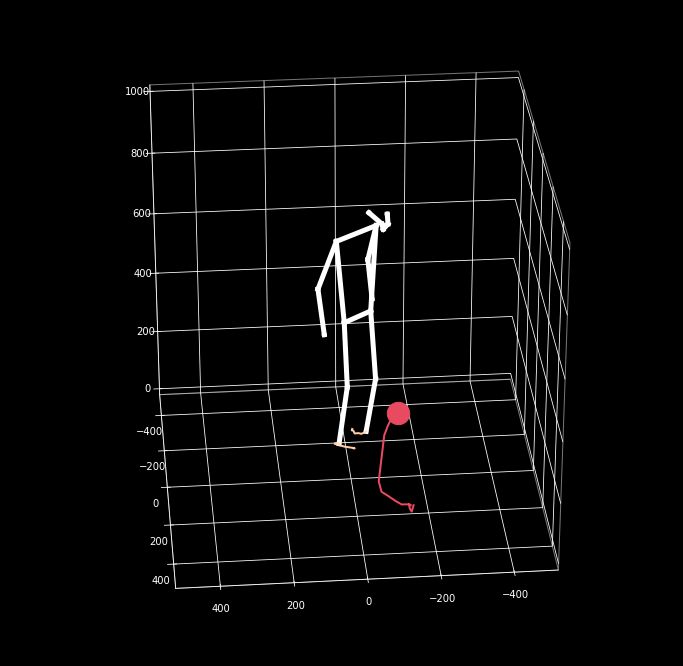

In [30]:
generate_frames(0, len(extracted_data_a))

In [ ]:
!ffmpeg -framerate 25 -pattern_type glob -i 'frames/*.png' -c:v libx264 -pix_fmt yuv420p out.mp4

ffmpeg version 3.4.11-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-li

In [ ]:
!rm -rf frames
!rm -rf out.mp4